# Import of different libraries and train & test files.

In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

['train.csv', 'sampleSubmission.csv', 'test.csv']


In [107]:
df_train = pd.read_csv('Data_Folder/train.csv')
df_test = pd.read_csv('Data_Folder/test.csv')

In [108]:
print(df_train.columns.values)
print(df_test.columns.values)


['datetime' 'season' 'holiday' 'workingday' 'weather' 'temp' 'atemp'
 'humidity' 'windspeed' 'casual' 'registered' 'count']
['datetime' 'season' 'holiday' 'workingday' 'weather' 'temp' 'atemp'
 'humidity' 'windspeed']


We compare labels from train and test files. There's more features in train than in test. Maybe we can delete them.

In [109]:
#Let have a see of the contents of our datas
df_train[:10]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


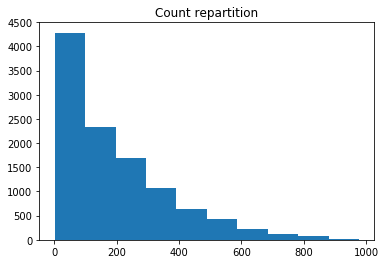

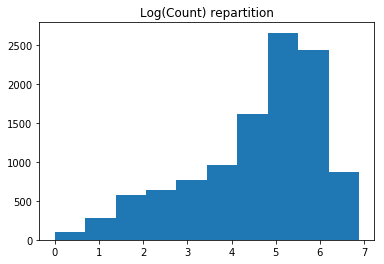

In [110]:
from math import log, exp

plt.hist(df_train["count"])
plt.title('Count repartition')
plt.show()

plt.hist(df_train["count"].apply(log))
plt.title('Log(Count) repartition')
plt.show()
#Gaussian ?

## Build of my Transformers
Datetime appears as the id, written like that we cannot use it. This is why we should convert it into Year, Month, Day, Hour.

In [111]:
#Custom Transformer which convert datetime column into hour, day, month, year, dayofweek columns
from sklearn.base import TransformerMixin
class TimeTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        temp=pd.DatetimeIndex(X['datetime'])
        cols = ['hour', 'day', 'month', 'year', 'dayofweek']
        X['hour'] = temp.hour
        X['day'] = temp.day
        X['month'] = temp.month
        X['year'] = temp.year
        X['dayofweek'] = temp.dayofweek
        return X

Thanks to the previous transformation datetime can be drop.

In [112]:
#Custom Transformer for dop a column
class DropTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xnew = X.drop(['datetime'], axis=1)
        return Xnew

Another Transformer to change type of few features

In [113]:
#Custom Transformer change the category of a column
class CategoryTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        categoryVariableList = ["hour","dayofweek","month","season","weather","holiday","workingday"]
        for var in categoryVariableList:
            X[var] = df_train[var].astype("category")
        return X

Creation of a Pipeline for apply all those modification to my training dataset

In [114]:
#Pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
        ('time', TimeTransformer()),
        ('drop', DropTransformer()),
        ('category', CategoryTransformer()),   
    ])

df_train_tr = pipeline.fit_transform(df_train)
df_test_tr = pipeline.transform(df_test)

In [115]:
#Correlation matrix between feetures
corr_matrix=df_train_tr.corr()
corr_matrix['count']

temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
count         1.000000
day           0.019826
year          0.260403
Name: count, dtype: float64

Lot of linear relation : 
Temp & Temp proportional
Hour
Humidity

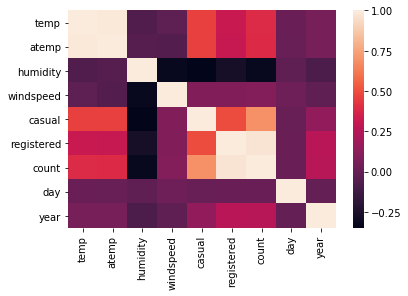

In [116]:
sns.heatmap(corr_matrix)

Let transform the count feature into Log(Let) features in order to have a better repartition

In [117]:
from math import log, exp

X = df_train_tr.drop(['casual', 'registered', 'count'], axis=1)
Y = df_train['count']
Ylog = df_train["count"].apply(log)

df_test_datetime = df_test['datetime']
X2 = df_test_tr

## Regression selection

In [118]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [119]:
#Decition Tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X, Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [120]:
#Cross validatoin sur le Decision tree
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, X, Y,
                                scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [ 48.89764614  70.54079439  55.49020215  58.10320605  68.13215026
  98.4209443  110.43229727  81.30355136  87.98349089 110.64040272]
Mean: 78.99446855130728
Standard deviation: 21.301392542705187


In [121]:
tree_reg_predictions_test = tree_reg.predict(X2)
tree_reg_predictions_test_df = pd.DataFrame(tree_reg_predictions_test)
tree_reg_predictions_test_df['count'] = tree_reg_predictions_test_df
df=pd.DataFrame({'datetime':df_test_datetime, 'count':tree_reg_predictions_test})
df.to_csv('Decision file.csv', sep=',', encoding = 'utf-8', index=False)


In [122]:
#On fit la random forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg_log =RandomForestRegressor(random_state=42)
forest_reg_log.fit(X, Ylog)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [123]:
#Cross validatoin sur le Random Forest
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X, Y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [50.51671909 52.16742648 43.29750171 45.03918241 49.16676126 90.28333118
 96.34562367 68.72451647 67.6689872  66.72575216]
Mean: 62.99358016458105
Standard deviation: 17.60703262414321


In [124]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [90, 150], 'max_features': [10]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [90, 150], 'max_features': [10]},
  ]

forest_reg_log = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_log = GridSearchCV(forest_reg_log, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search_log.fit(X,Ylog)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'n_estimators': [90, 150], 'max_features': [10]}, {'bootstrap': [False], 'n_estimators': [90, 150], 'max_features': [10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [125]:
forest_reg_best_log = grid_search_log.best_estimator_

In [126]:
print(grid_search_log.best_params_)

{'max_features': 10, 'n_estimators': 150}


In [127]:
cvres = grid_search_log.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.49229219038073274 {'max_features': 10, 'n_estimators': 90}
0.49036716306348765 {'max_features': 10, 'n_estimators': 150}
0.5093069522078029 {'bootstrap': False, 'max_features': 10, 'n_estimators': 90}
0.509894360722458 {'bootstrap': False, 'max_features': 10, 'n_estimators': 150}


In [128]:
pd.DataFrame(grid_search_log.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.361335,0.070262,0.089310,0.005344,10,90,NaN,"{'max_features': 10, 'n_estimators': 90}",-0.554493,-0.136380,-0.213124,-0.142358,-0.165260,-0.242352,0.158425,2,-1.356073e-02,-1.569736e-02,-1.483367e-02,-1.526921e-02,-1.587187e-02,-1.504657e-02,8.255020e-04
1,3.930101,0.024219,0.147933,0.007191,10,150,NaN,"{'max_features': 10, 'n_estimators': 150}",-0.556560,-0.136461,-0.204190,-0.141038,-0.163906,-0.240460,0.159894,1,-1.320122e-02,-1.526923e-02,-1.434617e-02,-1.500452e-02,-1.556236e-02,-1.467670e-02,8.401474e-04
2,3.719750,0.056573,0.098696,0.006339,10,90,False,"{'bootstrap': False, 'max_features': 10, 'n_es...",-0.566289,-0.164007,-0.241105,-0.150617,-0.174809,-0.259394,0.156612,3,-4.006815e-29,-3.681945e-29,-3.842918e-29,-3.715919e-29,-3.708920e-29,-3.791303e-29,1.212751e-30
3,6.106647,0.104458,0.162922,0.008626,10,150,False,"{'bootstrap': False, 'max_features': 10, 'n_es...",-0.566414,-0.161502,-0.245913,-0.148647,-0.177344,-0.259992,0.156878,4,-1.116221e-28,-1.024378e-28,-1.059378e-28,-9.692027e-29,-9.797161e-29,-1.029779e-28,5.395056e-30


In [129]:

forest_reg_prediction_test_best_log = forest_reg_best_log.predict(X2)

forest_reg_predictions_test_best_log=np.exp(forest_reg_prediction_test_best_log)

df_best_log = pd.DataFrame({'datetime':df_test_datetime, 'count':forest_reg_predictions_test_best_log})

df_best_log.to_csv('Forest best log file.csv', sep=',', encoding = 'utf-8', index=False)


In this part I want to test Xgboost and Gradiant boosting regressor. I'ma not able to use this Regressor with categorical value. This is why I have to make some modification

In [130]:

#Custom Transformer get dummies of my categorical columns
class GetDummiesTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        categoryVariableList = ["hour","dayofweek","month","season","weather","holiday","workingday"]
        for var in categoryVariableList:
            X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var)], axis=1)
        return X

In [131]:
#Creation of my second Pipeline for gradiant and XgBoost
from sklearn.pipeline import Pipeline
pipeline_dummies = Pipeline([
        ('time', TimeTransformer()),
        ('drop', DropTransformer()),
        ('category', CategoryTransformer()),
        ('dummies', GetDummiesTransformer())
    ])

df_train_tr2 = pipeline_dummies.fit_transform(df_train)
df_test_tr2 = pipeline_dummies.transform(df_test)


df_test_tr2

,temp,atemp,humidity,windspeed,day,year,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,holiday_0,holiday_1,workingday_0,workingday_1
0,10.66,11.365,56,26.0027,20,2011,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
1,10.66,13.635,56,0.0000,20,2011,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
2,10.66,13.635,56,0.0000,20,2011,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
3,10.66,12.880,56,11.0014,20,2011,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
4,10.66,12.880,56,11.0014,20,2011,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
5,9.84,11.365,60,15.0013,20,2011,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0
6,9.02,10.605,60,15.0013,20,2011,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
7,9.02,10.605,55,15.0013,20,2011,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
8,9.02,10.605,55,19.0012,20,2011,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
9,9.84,11.365,52,15.0013,20,2011,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0


In [132]:
X = df_train_tr2.drop(['casual', 'registered', 'count'], axis=1)
X2 = df_test_tr2

from sklearn.ensemble import GradientBoostingRegressor

Gb_reg = GradientBoostingRegressor()
Gb_reg.fit (X, Ylog)
Gb_reg_predictions = Gb_reg.predict(X2)
Gb_reg_predictions = np.exp(Gb_reg_predictions)
gb_df = pd.DataFrame({'datetime':df_test_datetime, 'count':Gb_reg_predictions})
gb_df.to_csv('Gb file.csv', sep=',', encoding = 'utf-8', index=False)

In [133]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(X, Ylog)
xgb_reg_predictions = xgb_reg.predict(X2)
xgb_reg_predictions = np.exp(xgb_reg_predictions)
xgb_df = pd.DataFrame({'datetime':df_test_datetime, 'count':xgb_reg_predictions})
xgb_df.to_csv('Xgb file.csv', sep=',', encoding = 'utf-8', index=False)
